In [1]:
%load_ext version_information

In [20]:
import datetime
from pprint import pprint

import spacepy.plot as spp
import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacepy import omni
from spacepy import time as spt
from spacepy import plot as spp
spp.revert_style()
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
import tqdm
from scipy import stats
import matplotlib
from sklearn.neighbors import KDTree
from spacepy import omni as omni
from spacepy import toolbox as tb
from spacepy import time as spt
from spacepy import datamodel as dm
import scipy
import h5py
import pymc3 as pm

import verify

%version_information numpy, matplotlib, version_information, verify, scipy, sklearn, seaborn, spacepy, h5py

Software,Version
Python,3.6.6 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython,7.1.1
OS,Darwin 17.7.0 x86_64 i386 64bit
numpy,1.15.4
matplotlib,3.0.1
version_information,1.0.3
verify,The 'verify' distribution was not found and is required by the application
scipy,1.1.0
sklearn,0.20.0
seaborn,0.9.0


# Load the CXD data and look for a probability distribution
Doing thia on the plane so a bunch of guessing

In [3]:
df = pd.read_hdf('../Data/CXD_Data.h5', 'Log_Flux_1.6_std')

In [4]:
df.head()

2001-02-20 08:00:00    0.471567
2001-02-20 16:00:00    0.254677
2001-02-21 00:00:00   -0.041419
2001-02-21 08:00:00    0.204187
2001-02-21 16:00:00    0.187263
Name: Log_Flux_1.6_std, dtype: float64

Text(0, 0.5, 'Log_Flux_1.6_std')

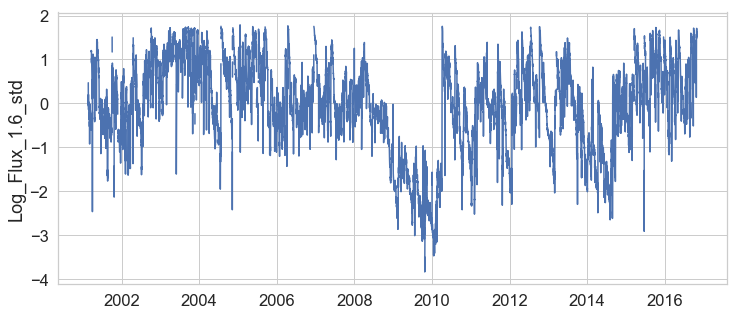

In [5]:
df.plot(figsize=(12,5))
plt.ylabel('Log_Flux_1.6_std')

Text(0, 0.5, 'Probability density')

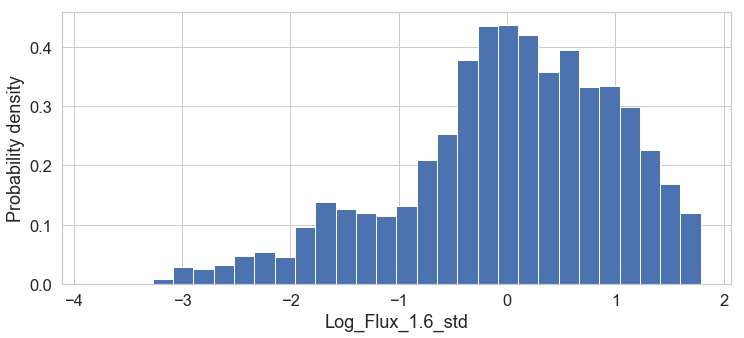

In [6]:
df.hist(bins=30, density=True, figsize=(12,5))
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

/Users/balarsen/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Probability density')

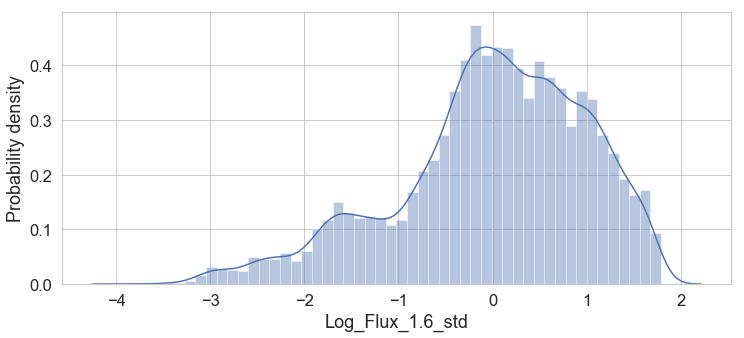

In [7]:
plt.figure(figsize=(12,5))
sns.distplot(df.dropna().values)
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

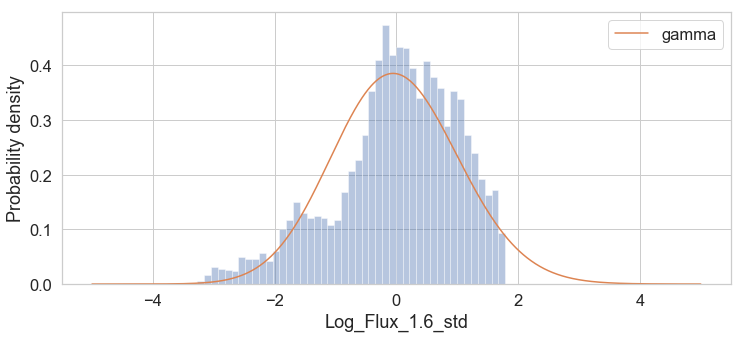

In [8]:
gamma_fit_p = stats.gamma.fit(df.dropna().values)
X = np.linspace(-5, 5, 1000)
Y = stats.gamma(*gamma_fit_p).pdf(X)
plt.figure(figsize=(12,5))
sns.distplot(df.dropna().values, norm_hist=True, kde=False)
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

plt.plot(X, Y, label='gamma')
plt.legend()

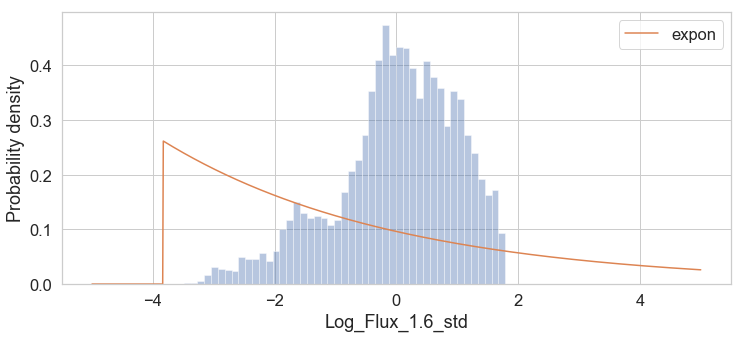

In [9]:
expon_fit_p = stats.expon.fit(df.dropna().values)
X = np.linspace(-5, 5, 1000)
Y = stats.expon(*expon_fit_p).pdf(X)
plt.figure(figsize=(12,5))
sns.distplot(df.dropna().values, norm_hist=True, kde=False)
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

plt.plot(X, Y, label='expon')
plt.legend()

/Users/balarsen/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


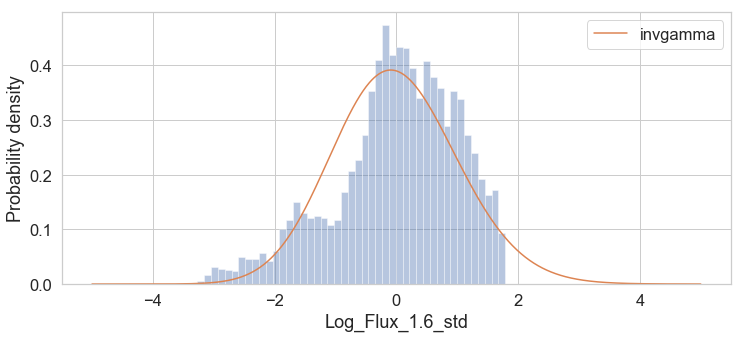

In [10]:
invgamma_fit_p = stats.invgamma.fit(df.dropna().values)
X = np.linspace(-5, 5, 1000)
Y = stats.invgamma(*invgamma_fit_p).pdf(X)
plt.figure(figsize=(12,5))
sns.distplot(df.dropna().values, norm_hist=True, kde=False)
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

plt.plot(X, Y, label='invgamma')
plt.legend()

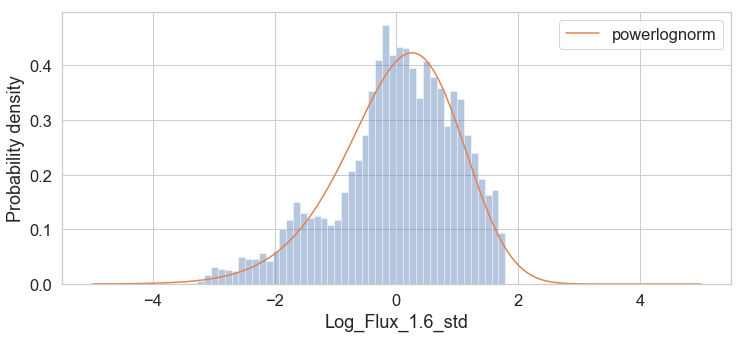

In [11]:
powerlognorm_fit_p = stats.powerlognorm.fit(df.dropna().values)
X = np.linspace(-5, 5, 1000)
Y = stats.powerlognorm(*powerlognorm_fit_p).pdf(X)
plt.figure(figsize=(12,5))
sns.distplot(df.dropna().values, norm_hist=True, kde=False)
plt.xlabel('Log_Flux_1.6_std')
plt.ylabel('Probability density')

plt.plot(X, Y, label='powerlognorm')
plt.legend()

This `powerlognorm` seems to fit well enough that if we wanted to sample from it we could. 

# Look for some correlations with flux and OMNI

In [12]:
with h5py.File('../Data/OMNI_Data.h5') as h5:
    keys = list(h5.keys())

omni = pd.DataFrame()
for c in keys:
    tmp = pd.read_hdf('../Data/OMNI_Data.h5', c)
    omni[c] = tmp

In [13]:
omni.head()

,BzIMF,BzIMF_std,BzIMF_std_mean,BzIMF_std_std,Dst,Dst_std,Dst_std_mean,Dst_std_std,Kp,Kp_std,...,akp3_std_mean,akp3_std_std,dens,dens_std,dens_std_mean,dens_std_std,velo,velo_std,velo_std_mean,velo_std_std
2001-01-01 00:00:00,-0.7,-0.225486,-0.028806,2.976654,-6.0,0.272227,-11.544908,20.36867,0.0,-1.299331,...,1.796845,1.260873,5.8,-0.037048,5.983682,4.957925,293.0,-1.322973,433.664596,106.32459
2001-01-01 08:00:00,-1.7,-0.561434,-0.028806,2.976654,-2.0,0.468607,-11.544908,20.36867,1.0,-0.576120,...,1.796845,1.260873,11.1,1.031948,5.983682,4.957925,285.0,-1.398215,433.664596,106.32459
2001-01-01 16:00:00,0.9,0.312030,-0.028806,2.976654,9.0,1.008652,-11.544908,20.36867,0.3,-1.082368,...,1.796845,1.260873,10.7,0.951268,5.983682,4.957925,274.0,-1.501671,433.664596,106.32459
2001-01-02 00:00:00,1.3,0.446409,-0.028806,2.976654,-3.0,0.419512,-11.544908,20.36867,1.3,-0.359156,...,1.796845,1.260873,13.9,1.596700,5.983682,4.957925,285.0,-1.398215,433.664596,106.32459
2001-01-02 08:00:00,0.9,0.312030,-0.028806,2.976654,11.0,1.106842,-11.544908,20.36867,0.0,-1.299331,...,1.796845,1.260873,10.8,0.971438,5.983682,4.957925,272.0,-1.520482,433.664596,106.32459


In [14]:
comb = pd.merge(omni, pd.DataFrame(df), left_index=True, right_index=True)

In [15]:
comb.head()

,BzIMF,BzIMF_std,BzIMF_std_mean,BzIMF_std_std,Dst,Dst_std,Dst_std_mean,Dst_std_std,Kp,Kp_std,...,akp3_std_std,dens,dens_std,dens_std_mean,dens_std_std,velo,velo_std,velo_std_mean,velo_std_std,Log_Flux_1.6_std
2001-02-20 08:00:00,-1.8,-0.595028,-0.028806,2.976654,7.0,0.910462,-11.544908,20.36867,0.7,-0.793083,...,1.260873,7.58,0.321973,5.983682,4.957925,291.0,-1.341784,433.664596,106.32459,0.471567
2001-02-20 16:00:00,6.2,2.092553,-0.028806,2.976654,2.0,0.664987,-11.544908,20.36867,1.3,-0.359156,...,1.260873,9.80,0.769741,5.983682,4.957925,325.0,-1.022008,433.664596,106.32459,0.254677
2001-02-21 00:00:00,-6.1,-2.039603,-0.028806,2.976654,-1.0,0.517702,-11.544908,20.36867,2.0,0.147092,...,1.260873,4.40,-0.319424,5.983682,4.957925,339.0,-0.890336,433.664596,106.32459,-0.041419
2001-02-21 08:00:00,-2.6,-0.863786,-0.028806,2.976654,-17.0,-0.267818,-11.544908,20.36867,1.3,-0.359156,...,1.260873,5.00,-0.198406,5.983682,4.957925,358.0,-0.711638,433.664596,106.32459,0.204187
2001-02-21 16:00:00,0.6,0.211246,-0.028806,2.976654,-3.0,0.419512,-11.544908,20.36867,1.3,-0.359156,...,1.260873,5.10,-0.178236,5.983682,4.957925,346.0,-0.824500,433.664596,106.32459,0.187263


In [16]:
comb.columns

Index(['BzIMF', 'BzIMF_std', 'BzIMF_std_mean', 'BzIMF_std_std', 'Dst',
       'Dst_std', 'Dst_std_mean', 'Dst_std_std', 'Kp', 'Kp_std', 'Kp_std_mean',
       'Kp_std_std', 'Pdyn', 'Pdyn_std', 'Pdyn_std_mean', 'Pdyn_std_std',
       'akp3', 'akp3_std', 'akp3_std_mean', 'akp3_std_std', 'dens', 'dens_std',
       'dens_std_mean', 'dens_std_std', 'velo', 'velo_std', 'velo_std_mean',
       'velo_std_std', 'Log_Flux_1.6_std'],
      dtype='object')

In [17]:
cols = [v for v in comb.columns if v.endswith('std') and 'std_std' not in v]
cols

['BzIMF_std',
 'Dst_std',
 'Kp_std',
 'Pdyn_std',
 'akp3_std',
 'dens_std',
 'velo_std',
 'Log_Flux_1.6_std']

/Users/balarsen/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/balarsen/miniconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


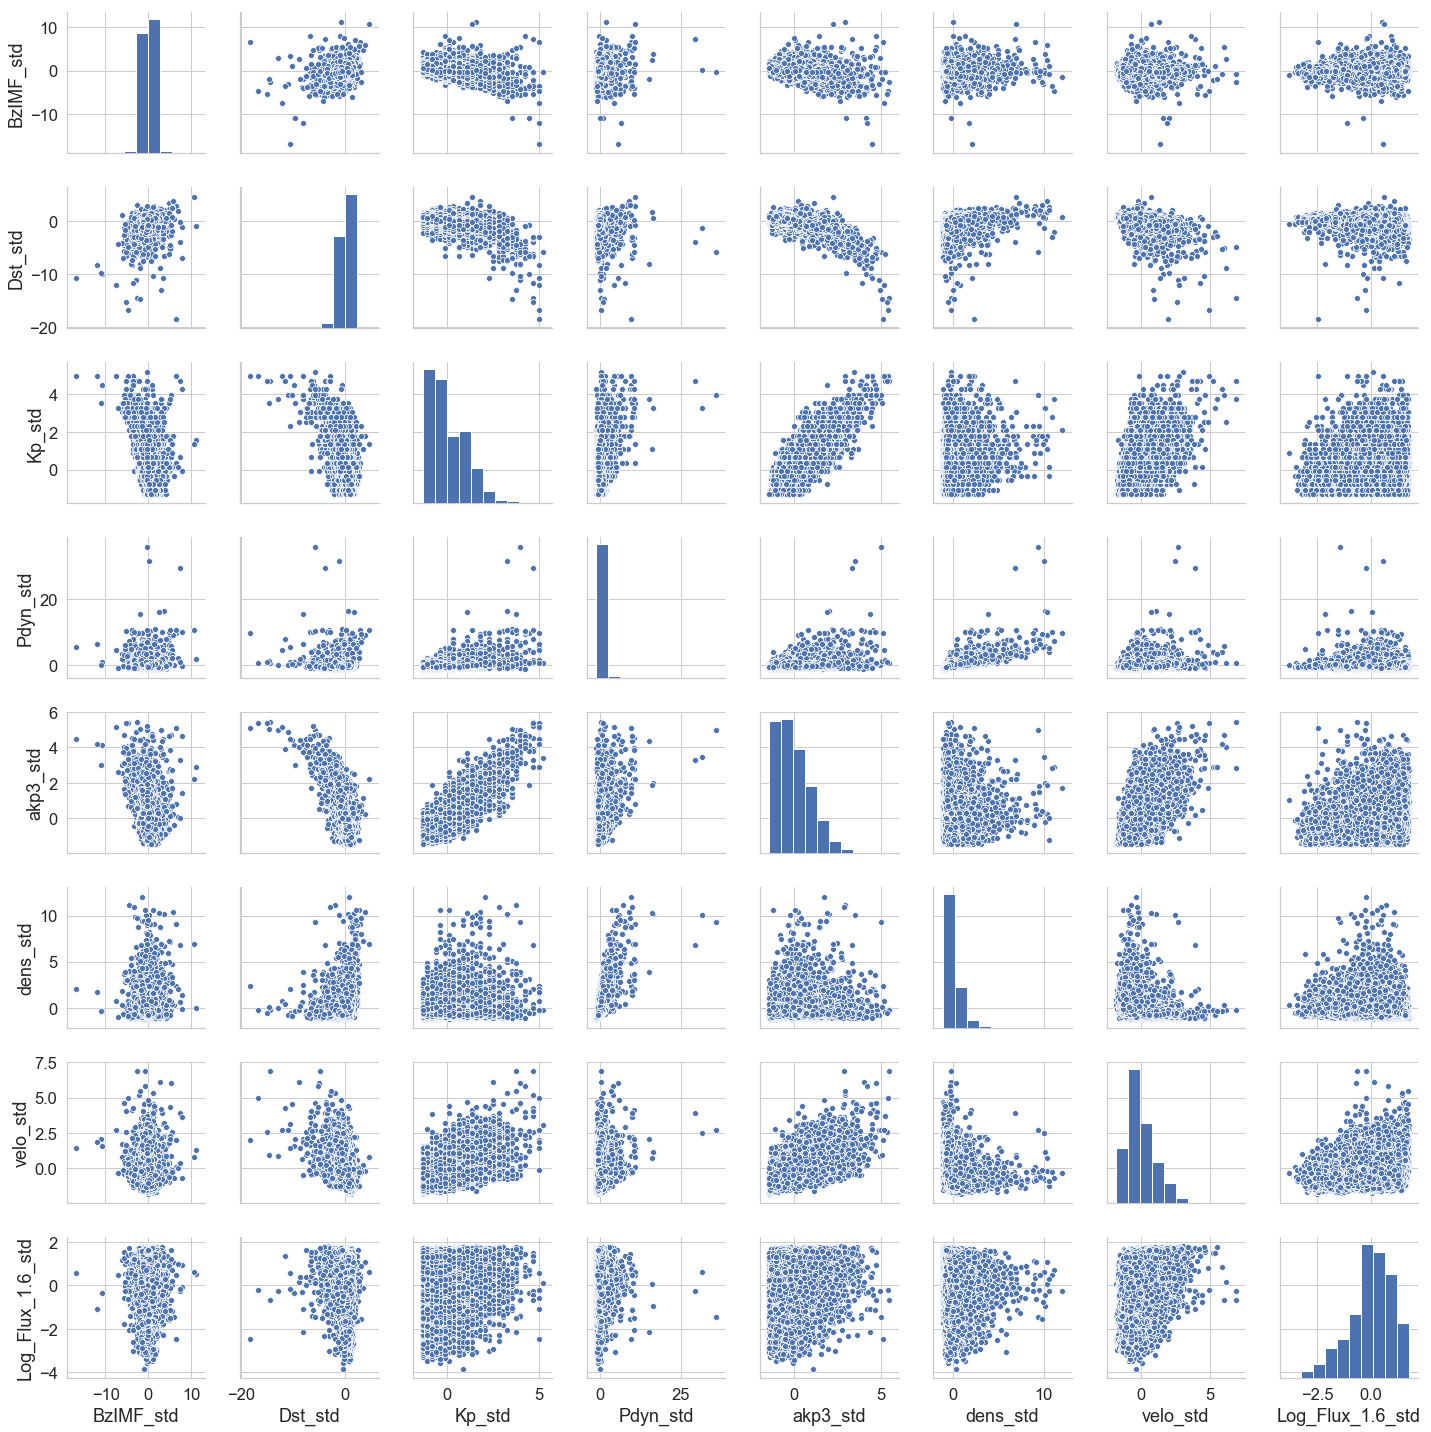

In [18]:
sns.pairplot(comb[cols], )


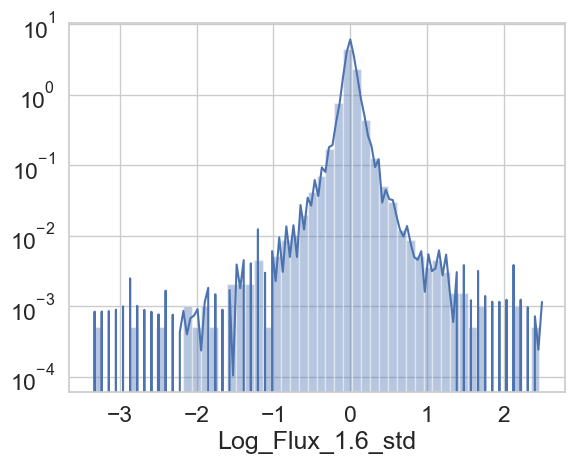

In [83]:
sns.distplot(df.diff().dropna())
plt.yscale('log')

/Users/balarsen/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


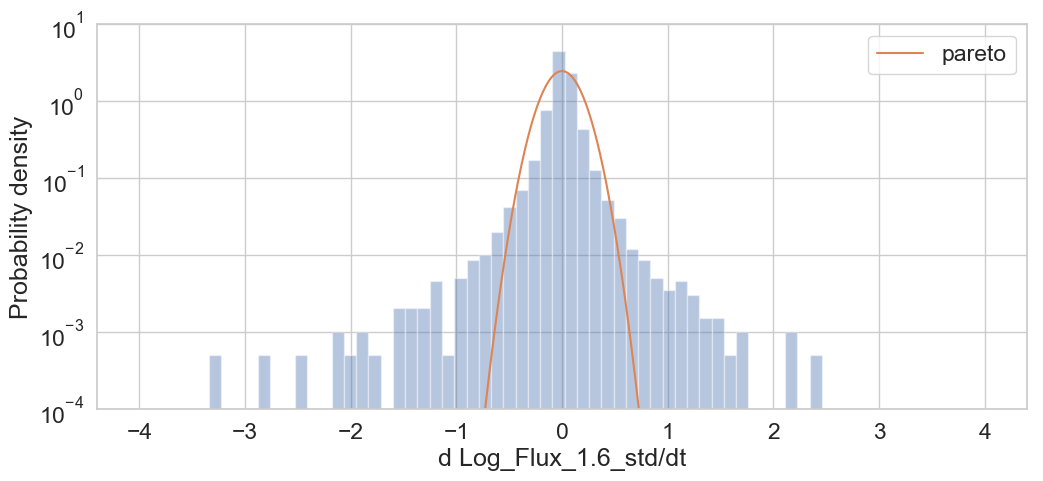

In [92]:
norm_fit_p = stats.norm.fit(df.diff().dropna().values)
X = np.linspace(-4, 4, 1000)
Y = stats.norm(*norm_fit_p).pdf(X)
plt.figure(figsize=(12,5))
sns.distplot(df.diff().dropna(), norm_hist=True, kde=False)
plt.xlabel('d Log_Flux_1.6_std/dt')
plt.ylabel('Probability density')

plt.plot(X, Y, label='norm')
plt.yscale('log')
plt.ylim((1e-4, 1e1))
plt.legend()

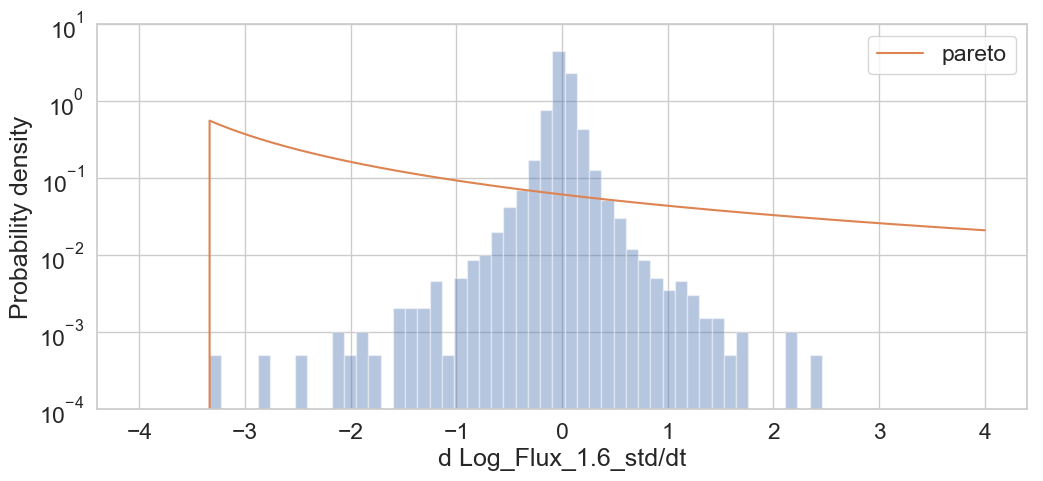

In [93]:
pareto_fit_p = stats.pareto.fit(df.diff().dropna().values)
X = np.linspace(-4, 4, 1000)
Y = stats.pareto(*pareto_fit_p).pdf(X)
plt.figure(figsize=(12,5))
sns.distplot(df.diff().dropna(), norm_hist=True, kde=False)
plt.xlabel('d Log_Flux_1.6_std/dt')
plt.ylabel('Probability density')

plt.plot(X, Y, label='pareto')
plt.yscale('log')
plt.ylim((1e-4, 1e1))
plt.legend()

# Look now for events and find a few

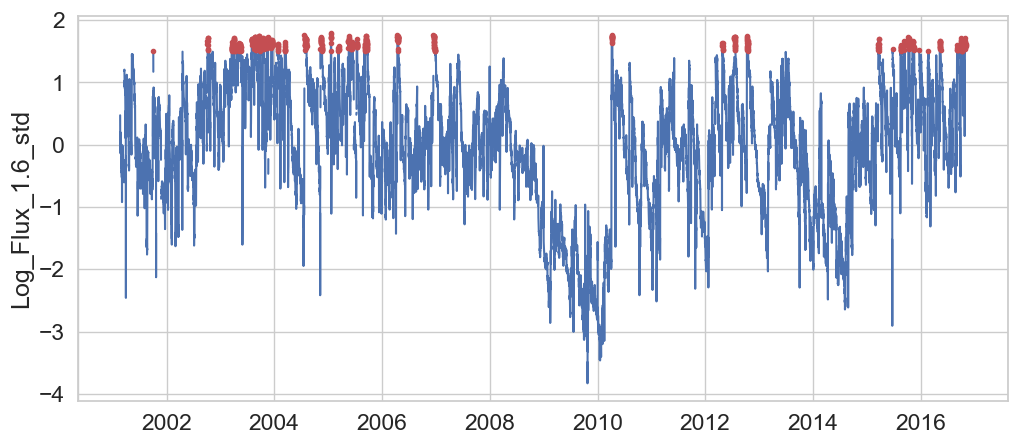

In [33]:
df.plot(figsize=(12,5))
plt.ylabel('Log_Flux_1.6_std')
df[df>1.5].plot(color='r', marker='.', linestyle='None')

In [25]:
df.describe()

count    17012.000000
mean        -0.003766
std          1.010387
min         -3.830331
25%         -0.524593
50%          0.094078
75%          0.737945
max          1.787722
Name: Log_Flux_1.6_std, dtype: float64

In [66]:
df2 = df[df>1.5]
df2.head(10)

2001-10-03 00:00:00    1.510295
2002-10-05 00:00:00    1.616543
2002-10-05 08:00:00    1.671968
2002-10-05 16:00:00    1.708074
2002-10-06 00:00:00    1.663822
2002-10-06 08:00:00    1.716753
2002-10-06 16:00:00    1.712265
2002-10-07 00:00:00    1.601437
2002-10-10 16:00:00    1.523166
2002-10-11 08:00:00    1.531216
Name: Log_Flux_1.6_std, dtype: float64

In [123]:
events = df2.sample(10).sort_index().index
events

DatetimeIndex(['2002-10-06 16:00:00', '2003-03-22 08:00:00',
               '2003-05-09 00:00:00', '2003-10-22 08:00:00',
               '2003-10-23 00:00:00', '2003-11-16 16:00:00',
               '2006-04-22 08:00:00', '2006-12-22 00:00:00',
               '2012-07-22 16:00:00', '2016-05-12 08:00:00'],
              dtype='datetime64[ns]', freq=None)

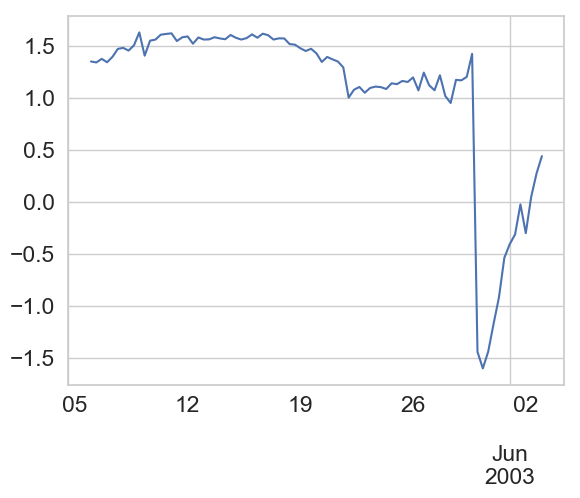

In [121]:
df.loc[events[0]-datetime.timedelta(days=7):events[0]+datetime.timedelta(days=21)].plot()

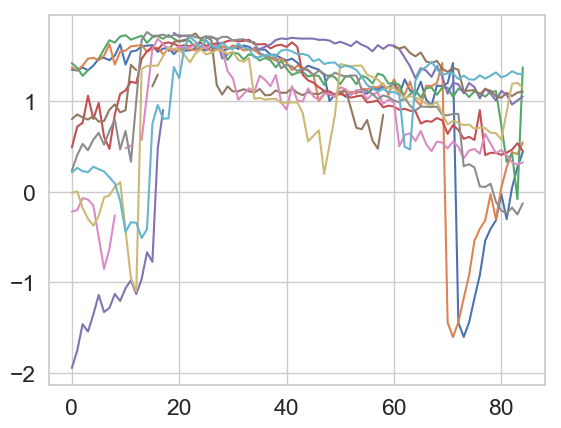

In [122]:
for e in events:
    plt.plot(df.loc[e-datetime.timedelta(days=7):e+datetime.timedelta(days=21)].values)